<a href="https://colab.research.google.com/github/DanteBM/Aprendizaje-Profundo/blob/main/tareas/tarea2/tarea2a_ap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. Discute tus resultados.

# Preparativos

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CIFAR10

import torchvision.transforms as T
from tqdm import trange

import random
# tomar n elementos de una secuencia
from itertools import islice as take

In [ ]:
images_path = "."
cifar_train_ds = CIFAR10(root=images_path, train=True, 
                      download=False, transform=T.ToTensor())
cifar_test_ds = CIFAR10(root=images_path, train=False, 
                     download=False, transform=T.ToTensor())

In [ ]:
# tamaño del lote
BATCH_SIZE = 32

# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    # (batch x C x H x W)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:4])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed(42)



dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dev # uso de GPU

device(type='cuda', index=0)

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


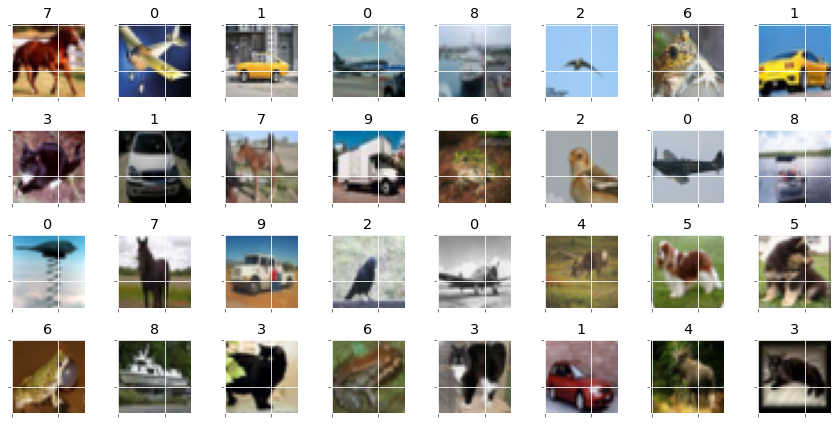

In [ ]:
# creamos un DataLoader
cifar_train_dl = DataLoader(
    # conjunto
    cifar_train_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(cifar_train_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## Creación de dataloaders

In [ ]:
cifar_train_dl = DataLoader(
    # conjunto
    cifar_train_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

cifar_test_dl = DataLoader(
    # conjunto
    cifar_test_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

## Funciones para entrenar

In [ ]:
def train_epoch(dl, model, opt):
    for x, y_true in dl:
        x, y_true = x.to(dev), y_true.to(dev)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            x, y_true = x.to(dev), y_true.to(dev)
            
            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):
    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch+1:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [ ]:
def plot_evaluation(loss_hist, acc_hist):
    fig, ax = plt.subplots(ncols=2, figsize=(16,9))
    trn_loss, tst_loss = zip(*loss_hist)
    ax[0].plot(trn_loss, 'tab:orange', label='train loss')
    ax[0].plot(tst_loss, 'tab:red', label='test loss')
    ax[0].legend(loc='upper right')
    ax[0].set_xlabel('época')
    ax[0].set_ylabel('pérdida')
    
    trn_acc, tst_acc = zip(*acc_hist)
    ax[1].plot(trn_acc, 'tab:green', label='train acc')
    ax[1].plot(tst_acc, 'tab:blue', label='test acc')
    ax[1].legend(loc='lower right')
    ax[1].set_xlabel('época')
    ax[1].set_ylabel('exactitud')
    plt.show()

# Modelado

## Modelo 1: minimalista

In [ ]:
class CIFAR10Conv1(nn.Module):
    def __init__(self, out_channels, kernel_size=1):
        super().__init__()
        
        in_channels = 3
        input_dim = 32 # H = W
                
        self.seq = nn.Sequential(
            # [M,3,H,W]
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size),
            nn.ReLU(),
            
            # Clasificador
            nn.Flatten(),
            nn.Linear(out_channels*(input_dim - kernel_size + 1)**2, out_features=10),
        )
        
    def forward(self,x):
        y = self.seq(x)
        return y

  3%|▎         | 1/30 [00:17<08:39, 17.90s/it]

E01 loss=[197.63,197.48] acc=[32.53,32.89]


  7%|▋         | 2/30 [00:30<06:48, 14.59s/it]

E02 loss=[188.38,188.16] acc=[34.51,34.54]


 10%|█         | 3/30 [00:43<06:14, 13.85s/it]

E03 loss=[183.65,183.75] acc=[36.89,36.73]


 13%|█▎        | 4/30 [00:55<05:43, 13.21s/it]

E04 loss=[180.77,181.03] acc=[37.44,37.31]


 17%|█▋        | 5/30 [01:07<05:21, 12.86s/it]

E05 loss=[177.68,178.05] acc=[38.85,38.22]


 20%|██        | 6/30 [01:19<05:04, 12.67s/it]

E06 loss=[175.13,175.44] acc=[39.90,39.24]


 23%|██▎       | 7/30 [01:32<04:53, 12.78s/it]

E07 loss=[173.27,173.75] acc=[40.33,39.71]


 27%|██▋       | 8/30 [01:45<04:38, 12.66s/it]

E08 loss=[171.86,172.40] acc=[40.76,40.41]


 30%|███       | 9/30 [01:58<04:28, 12.77s/it]

E09 loss=[169.75,170.39] acc=[41.59,41.13]


 33%|███▎      | 10/30 [02:10<04:13, 12.66s/it]

E10 loss=[168.42,169.20] acc=[42.25,41.46]


 37%|███▋      | 11/30 [02:23<04:03, 12.80s/it]

E11 loss=[167.36,168.09] acc=[42.08,41.35]


 40%|████      | 12/30 [02:36<03:50, 12.82s/it]

E12 loss=[165.96,166.82] acc=[43.15,42.62]


 43%|████▎     | 13/30 [02:49<03:37, 12.82s/it]

E13 loss=[164.79,165.79] acc=[43.52,42.74]


 47%|████▋     | 14/30 [03:01<03:22, 12.67s/it]

E14 loss=[163.89,164.79] acc=[43.97,42.73]


 50%|█████     | 15/30 [03:14<03:08, 12.60s/it]

E15 loss=[162.74,163.82] acc=[44.05,43.11]


 53%|█████▎    | 16/30 [03:26<02:54, 12.49s/it]

E16 loss=[161.61,162.72] acc=[44.44,43.39]


 57%|█████▋    | 17/30 [03:39<02:44, 12.67s/it]

E17 loss=[160.52,161.81] acc=[44.82,43.75]


 60%|██████    | 18/30 [03:52<02:33, 12.81s/it]

E18 loss=[159.68,160.99] acc=[44.94,43.71]


 63%|██████▎   | 19/30 [04:05<02:19, 12.68s/it]

E19 loss=[158.33,159.75] acc=[45.77,44.38]


 67%|██████▋   | 20/30 [04:17<02:05, 12.57s/it]

E20 loss=[157.37,159.05] acc=[45.74,44.45]


 70%|███████   | 21/30 [04:29<01:52, 12.46s/it]

E21 loss=[156.95,158.61] acc=[45.62,44.42]


 73%|███████▎  | 22/30 [04:41<01:38, 12.29s/it]

E22 loss=[154.72,156.53] acc=[46.42,45.22]


 77%|███████▋  | 23/30 [04:53<01:24, 12.12s/it]

E23 loss=[153.45,155.23] acc=[47.02,45.35]


 80%|████████  | 24/30 [05:05<01:13, 12.23s/it]

E24 loss=[152.20,154.22] acc=[47.46,46.18]


 83%|████████▎ | 25/30 [05:17<01:00, 12.13s/it]

E25 loss=[150.63,152.88] acc=[48.05,46.80]


 87%|████████▋ | 26/30 [05:29<00:48, 12.07s/it]

E26 loss=[149.65,152.18] acc=[48.47,46.79]


 90%|█████████ | 27/30 [05:42<00:36, 12.27s/it]

E27 loss=[148.63,151.32] acc=[48.48,46.44]


 93%|█████████▎| 28/30 [05:54<00:24, 12.31s/it]

E28 loss=[147.18,149.88] acc=[48.74,47.00]


 97%|█████████▋| 29/30 [06:07<00:12, 12.38s/it]

E29 loss=[145.79,148.80] acc=[49.13,47.66]


100%|██████████| 30/30 [06:19<00:00, 12.66s/it]

E30 loss=[144.67,147.86] acc=[49.72,47.78]


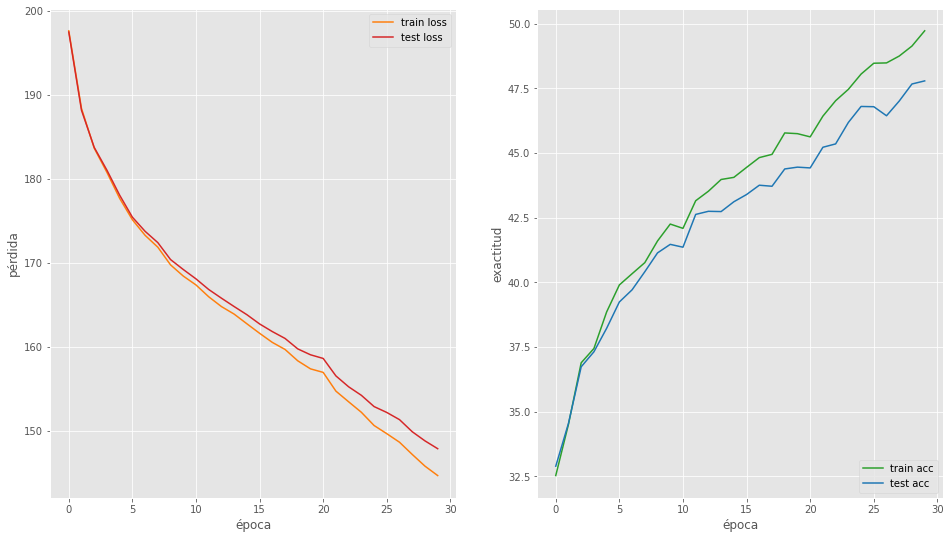

In [ ]:
modelo1 = CIFAR10Conv1(out_channels=6, kernel_size=3).to(dev)
loss_hist, acc_hist = train(modelo1, cifar_train_dl, cifar_test_dl, epochs=30)

plot_evaluation(loss_hist, acc_hist)

## Modelo 2

In [ ]:
class CIFAR10Conv2(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        input_dim = 32 # H = W
                
        self.seq = nn.Sequential(
            # [M,3,32,32] -> [M, 6, 30,30]
            nn.Conv2d(in_channels, 6, kernel_size=6),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            
            # [M, 6, 27,27] -> [M, 10, 25,25]
            nn.Conv2d(6, 10, kernel_size=3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            
            # Clasificador
            nn.Flatten(),
            nn.Linear(10*25*25, out_features=10)
        )
        
    def forward(self,x):
        y = self.seq(x)
        return y

  3%|▎         | 1/30 [00:14<07:10, 14.83s/it]

E01 loss=[158.26,158.33] acc=[44.40,44.02]


  7%|▋         | 2/30 [00:29<06:47, 14.54s/it]

E02 loss=[148.83,150.60] acc=[47.51,46.49]


 10%|█         | 3/30 [00:43<06:31, 14.50s/it]

E03 loss=[140.30,143.94] acc=[50.05,48.97]


 13%|█▎        | 4/30 [00:58<06:17, 14.52s/it]

E04 loss=[134.12,138.87] acc=[52.60,50.36]


 17%|█▋        | 5/30 [01:12<06:04, 14.59s/it]

E05 loss=[131.90,137.58] acc=[53.12,50.80]


 20%|██        | 6/30 [01:26<05:45, 14.41s/it]

E06 loss=[127.02,134.59] acc=[55.27,52.32]


 23%|██▎       | 7/30 [01:41<05:32, 14.47s/it]

E07 loss=[124.91,133.42] acc=[56.03,52.63]


 27%|██▋       | 8/30 [01:55<05:13, 14.24s/it]

E08 loss=[121.24,131.20] acc=[57.69,54.19]


 30%|███       | 9/30 [02:09<05:00, 14.30s/it]

E09 loss=[119.39,130.19] acc=[58.56,53.93]


 33%|███▎      | 10/30 [02:23<04:42, 14.14s/it]

E10 loss=[115.04,126.60] acc=[60.03,55.30]


 37%|███▋      | 11/30 [02:37<04:27, 14.10s/it]

E11 loss=[112.96,125.74] acc=[60.94,55.52]


 40%|████      | 12/30 [02:51<04:14, 14.13s/it]

E12 loss=[110.92,125.18] acc=[61.51,55.85]


 43%|████▎     | 13/30 [03:06<04:01, 14.21s/it]

E13 loss=[109.05,124.44] acc=[62.45,56.20]


 47%|████▋     | 14/30 [03:20<03:48, 14.26s/it]

E14 loss=[106.25,122.51] acc=[63.58,57.36]


 50%|█████     | 15/30 [03:34<03:33, 14.26s/it]

E15 loss=[104.64,122.14] acc=[64.07,57.27]


 53%|█████▎    | 16/30 [03:48<03:17, 14.14s/it]

E16 loss=[103.77,122.44] acc=[64.42,57.45]


 57%|█████▋    | 17/30 [04:02<03:02, 14.06s/it]

E17 loss=[111.04,130.05] acc=[61.74,54.78]


 60%|██████    | 18/30 [04:16<02:47, 13.96s/it]

E18 loss=[ 99.59,120.68] acc=[66.01,57.81]


 63%|██████▎   | 19/30 [04:29<02:32, 13.87s/it]

E19 loss=[ 98.20,120.31] acc=[66.73,58.33]


 67%|██████▋   | 20/30 [04:44<02:20, 14.04s/it]

E20 loss=[ 99.43,122.59] acc=[65.99,57.37]


 70%|███████   | 21/30 [04:58<02:06, 14.07s/it]

E21 loss=[ 96.60,121.11] acc=[67.29,57.98]


 73%|███████▎  | 22/30 [05:12<01:51, 13.92s/it]

E22 loss=[ 95.08,119.91] acc=[67.90,58.02]


 77%|███████▋  | 23/30 [05:25<01:37, 13.88s/it]

E23 loss=[ 93.29,119.31] acc=[68.24,58.51]


 80%|████████  | 24/30 [05:40<01:23, 13.99s/it]

E24 loss=[ 92.44,119.73] acc=[68.63,58.57]


 83%|████████▎ | 25/30 [05:53<01:09, 13.87s/it]

E25 loss=[ 90.27,118.85] acc=[69.32,58.70]


 87%|████████▋ | 26/30 [06:07<00:55, 13.85s/it]

E26 loss=[ 91.11,120.91] acc=[68.81,58.37]


 90%|█████████ | 27/30 [06:21<00:41, 13.83s/it]

E27 loss=[ 88.56,119.82] acc=[69.88,58.88]


 93%|█████████▎| 28/30 [06:35<00:27, 13.83s/it]

E28 loss=[ 88.61,120.37] acc=[69.92,59.09]


 97%|█████████▋| 29/30 [06:49<00:14, 14.01s/it]

E29 loss=[ 89.04,121.95] acc=[69.73,58.01]


100%|██████████| 30/30 [07:02<00:00, 14.10s/it]

E30 loss=[ 85.47,119.84] acc=[71.05,59.03]


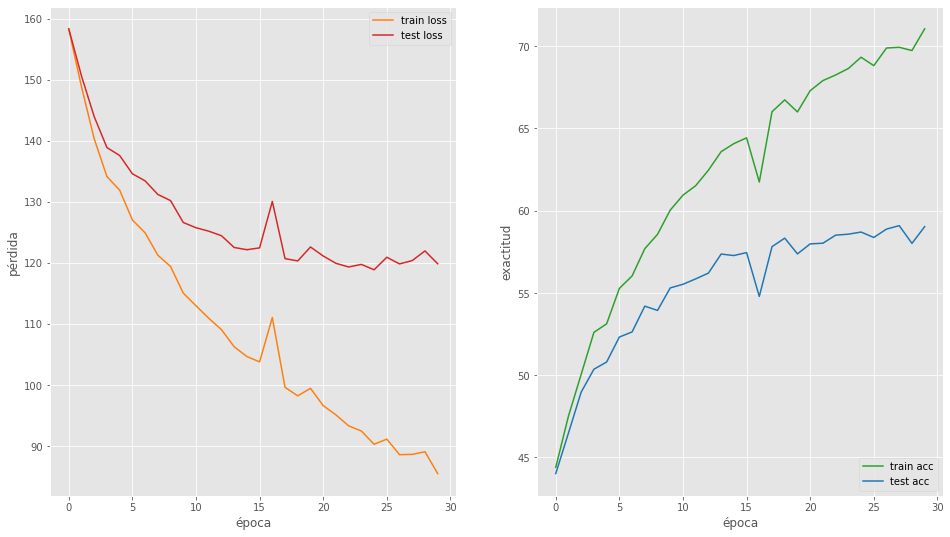

In [ ]:
modelo2 = CIFAR10Conv2(in_channels=3).to(dev)
loss_hist, acc_hist = train(modelo2, cifar_train_dl, cifar_test_dl, epochs=30)

plot_evaluation(loss_hist, acc_hist)

## Modelo 3

In [ ]:
class CIFAR10Conv3(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        input_dim = 32 # H = W
                
        self.seq = nn.Sequential(
            # [M,3,32,32] -> [M, 6, 30,30]
            nn.Conv2d(in_channels, 6, kernel_size=6),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            
            # [M, 6, 27,27] -> [M, 10, 25,25]
            nn.Conv2d(6, 10, kernel_size=3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            
            # [M, 10, 25,25] -> [M, 15, 15, 15]
            nn.Conv2d(10, 15, kernel_size=11),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            
            # Clasificador
            nn.Flatten(),
            nn.Linear(15**3, out_features=842),
            nn.ReLU(),
            
            nn.Linear(842, 210),
            nn.ReLU(),
            
            nn.Linear(210, 52),
            nn.ReLU(),
            
            nn.Linear(52, 10)
        )
        
    def forward(self,x):
        y = self.seq(x)
        return y

  3%|▎         | 1/30 [00:17<08:19, 17.23s/it]

E01 loss=[228.91,228.98] acc=[14.68,14.34]


  7%|▋         | 2/30 [00:34<08:00, 17.18s/it]

E02 loss=[219.95,219.99] acc=[19.54,19.29]


 10%|█         | 3/30 [00:50<07:32, 16.76s/it]

E03 loss=[191.60,191.66] acc=[28.62,28.50]


 13%|█▎        | 4/30 [01:07<07:14, 16.71s/it]

E04 loss=[174.06,173.75] acc=[34.08,33.85]


 17%|█▋        | 5/30 [01:24<07:04, 16.98s/it]

E05 loss=[163.30,163.20] acc=[38.27,38.55]


 20%|██        | 6/30 [01:41<06:45, 16.90s/it]

E06 loss=[155.51,155.88] acc=[41.07,41.35]


 23%|██▎       | 7/30 [01:58<06:27, 16.87s/it]

E07 loss=[149.20,149.56] acc=[44.08,44.38]


 27%|██▋       | 8/30 [02:15<06:15, 17.08s/it]

E08 loss=[144.68,144.97] acc=[46.31,46.45]


 30%|███       | 9/30 [02:33<05:59, 17.14s/it]

E09 loss=[139.81,140.63] acc=[48.36,47.87]


 33%|███▎      | 10/30 [02:50<05:44, 17.22s/it]

E10 loss=[137.93,138.25] acc=[49.52,49.31]


 37%|███▋      | 11/30 [03:07<05:27, 17.25s/it]

E11 loss=[131.31,132.90] acc=[52.13,51.75]


 40%|████      | 12/30 [03:24<05:06, 17.05s/it]

E12 loss=[128.05,129.66] acc=[53.63,52.89]


 43%|████▎     | 13/30 [03:41<04:51, 17.17s/it]

E13 loss=[124.00,126.39] acc=[55.27,53.81]


 47%|████▋     | 14/30 [03:58<04:33, 17.09s/it]

E14 loss=[121.39,124.37] acc=[56.14,55.16]


 50%|█████     | 15/30 [04:15<04:14, 16.99s/it]

E15 loss=[119.25,122.33] acc=[57.19,56.41]


 53%|█████▎    | 16/30 [04:32<03:55, 16.85s/it]

E16 loss=[116.60,121.38] acc=[58.29,56.26]


 57%|█████▋    | 17/30 [04:49<03:41, 17.02s/it]

E17 loss=[112.42,117.56] acc=[59.40,57.74]


 60%|██████    | 18/30 [05:05<03:22, 16.85s/it]

E18 loss=[112.75,117.83] acc=[59.46,57.36]


 63%|██████▎   | 19/30 [05:23<03:06, 16.99s/it]

E19 loss=[109.13,114.58] acc=[60.67,58.92]


 67%|██████▋   | 20/30 [05:40<02:50, 17.07s/it]

E20 loss=[107.98,114.07] acc=[61.37,59.28]


 70%|███████   | 21/30 [05:57<02:34, 17.13s/it]

E21 loss=[108.39,114.91] acc=[61.21,58.91]


 73%|███████▎  | 22/30 [06:14<02:15, 16.92s/it]

E22 loss=[103.13,110.70] acc=[63.12,60.32]


 77%|███████▋  | 23/30 [06:30<01:57, 16.82s/it]

E23 loss=[101.81,109.82] acc=[63.58,60.57]


 80%|████████  | 24/30 [06:47<01:40, 16.81s/it]

E24 loss=[100.05,108.91] acc=[64.40,61.12]


 83%|████████▎ | 25/30 [07:04<01:23, 16.77s/it]

E25 loss=[ 99.92,109.00] acc=[64.04,61.11]


 87%|████████▋ | 26/30 [07:20<01:06, 16.60s/it]

E26 loss=[ 98.72,108.54] acc=[64.75,61.46]


 90%|█████████ | 27/30 [07:37<00:50, 16.71s/it]

E27 loss=[ 95.85,107.74] acc=[65.75,61.48]


 93%|█████████▎| 28/30 [07:53<00:33, 16.58s/it]

E28 loss=[ 96.52,107.81] acc=[65.45,61.40]


 97%|█████████▋| 29/30 [08:09<00:16, 16.43s/it]

E29 loss=[ 93.81,105.73] acc=[66.58,62.56]


100%|██████████| 30/30 [08:26<00:00, 16.89s/it]

E30 loss=[ 92.23,105.48] acc=[67.28,62.64]


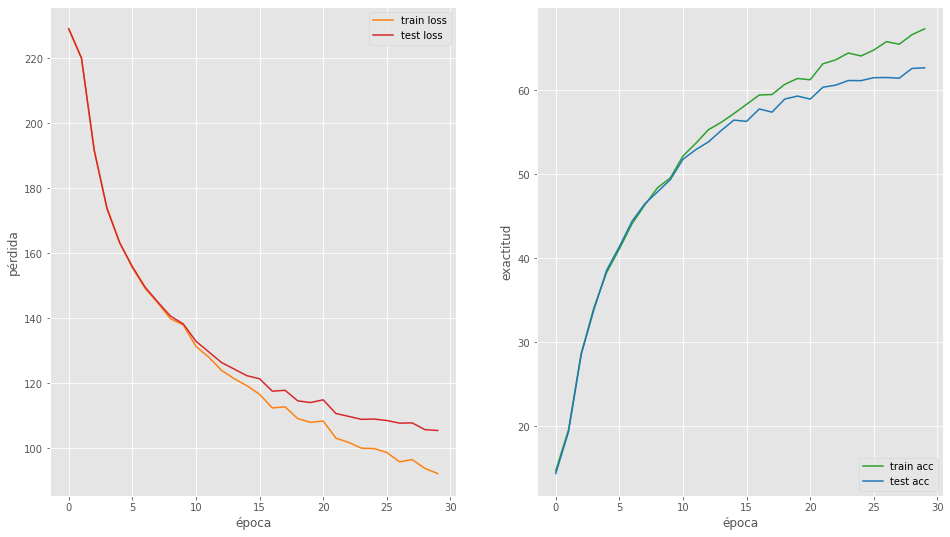

In [ ]:
modelo3 = CIFAR10Conv3(in_channels=3).to(dev)
loss_hist, acc_hist = train(modelo3, cifar_train_dl, cifar_test_dl, epochs=30)

plot_evaluation(loss_hist, acc_hist)

Se crearon distintos modelos, empezando desde lo más sencillo, y luego se le fueron agregando más capas.

El primer modelo es el minimalista porque es la arquitectura mínima para el problema. No obstante, vemos que con las 30 épicas no es suficiente alcanzar el 50% de accuracy.

A este modelo se le agregaron más capas de convolución, así como normalizaciones de lote. Como es de esperar, los resultados mejoran a casi 60%.

El último modelo explora la idea de mejorar el clasificador del modelo, agregando capas densas. Los resultados fueron mejores, aunque por poco, a lo que me lleva pensar que, en busca de mejorar un modelo, es preferible aumentar la arquitectura de la convolución, y no la del clasificador